# The Packages

In [1]:
import numpy as np
import pandas as pd
import os
import gc
import datetime
import warnings

In [2]:
# PACF - ACF
# ------------------------------------------------------
import statsmodels.api as sm


In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
import tensorflow as tf
import math 
# keras = tf.keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
from tensorflow.keras import losses
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.utils import plot_model

In [5]:
tf.__version__

'2.10.1'

In [6]:
# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import plotly.express as px


In [7]:
# CONFIGURATIONS
# ------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

# Utility Functions

In [8]:
def plotSeries(time, series, lab,form='-'):
    plt.plot(time, series, form, label=lab)
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.grid(True)

# The Data

In [9]:
wfc = pd.read_csv('Dataset/WFC Daily1.csv')

In [10]:
wfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,20.16,20.19,19.00,19.56,10.44,9037000
1,2000-01-04,18.62,18.84,18.00,18.59,9.92,15237200
2,2000-01-05,18.50,18.88,18.03,18.41,9.82,8228200
3,2000-01-06,18.53,19.50,18.47,19.22,10.25,8326800
4,2000-01-07,19.62,19.84,19.28,19.56,10.44,7711200


In [11]:
wfc.Date.dtype

dtype('O')

In [12]:
wfc['Date'] = pd.to_datetime(wfc['Date'])
#wfc.set_index(['Date'],inplace=True)

In [13]:
wfc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,20.16,20.19,19.00,19.56,10.44,9037000
1,2000-01-04,18.62,18.84,18.00,18.59,9.92,15237200
2,2000-01-05,18.50,18.88,18.03,18.41,9.82,8228200
3,2000-01-06,18.53,19.50,18.47,19.22,10.25,8326800
4,2000-01-07,19.62,19.84,19.28,19.56,10.44,7711200


In [14]:
wfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5754 entries, 0 to 5753
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       5754 non-null   datetime64[ns]
 1   Open       5754 non-null   float64       
 2   High       5754 non-null   float64       
 3   Low        5754 non-null   float64       
 4   Close      5754 non-null   float64       
 5   Adj Close  5754 non-null   float64       
 6   Volume     5754 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 314.8 KB


# The Split

In [15]:
min_date = wfc.Date.min()
max_date = wfc.Date.max()
print("Min:", min_date, "Max:", max_date)

Min: 2000-01-03 00:00:00 Max: 2022-11-11 00:00:00


In [16]:
train_percent = .75
valid_percent = .12

time_between = max_date - min_date

train_cutoff = min_date + train_percent*time_between
valid_cutoff = min_date + (train_percent + valid_percent)*time_between

print("Training Cutoff Date: {:s}".format(str(train_cutoff)))
print("Validation Cutoff Date: {:s}".format(str(valid_cutoff)))

Training Cutoff Date: 2017-02-23 00:00:00
Validation Cutoff Date: 2019-11-21 18:14:24


In [17]:
train_df = wfc[wfc.Date <= train_cutoff]
valid_df = wfc[(wfc.Date > train_cutoff) & (wfc.Date <= valid_cutoff)]
test_df = wfc[wfc.Date > valid_cutoff]


In [18]:
print("Dataset shape: {:s}".format(str(wfc.shape)))
print("Train dataset shape: {:s}".format(str(train_df.shape)))
print("Vaid dataset shape: {:s}".format(str(valid_df.shape)))
print("Test dataset shape: {:s}".format(str(test_df.shape)))

Dataset shape: (5754, 7)
Train dataset shape: (4313, 7)
Vaid dataset shape: (692, 7)
Test dataset shape: (749, 7)


# Stock Price Graph

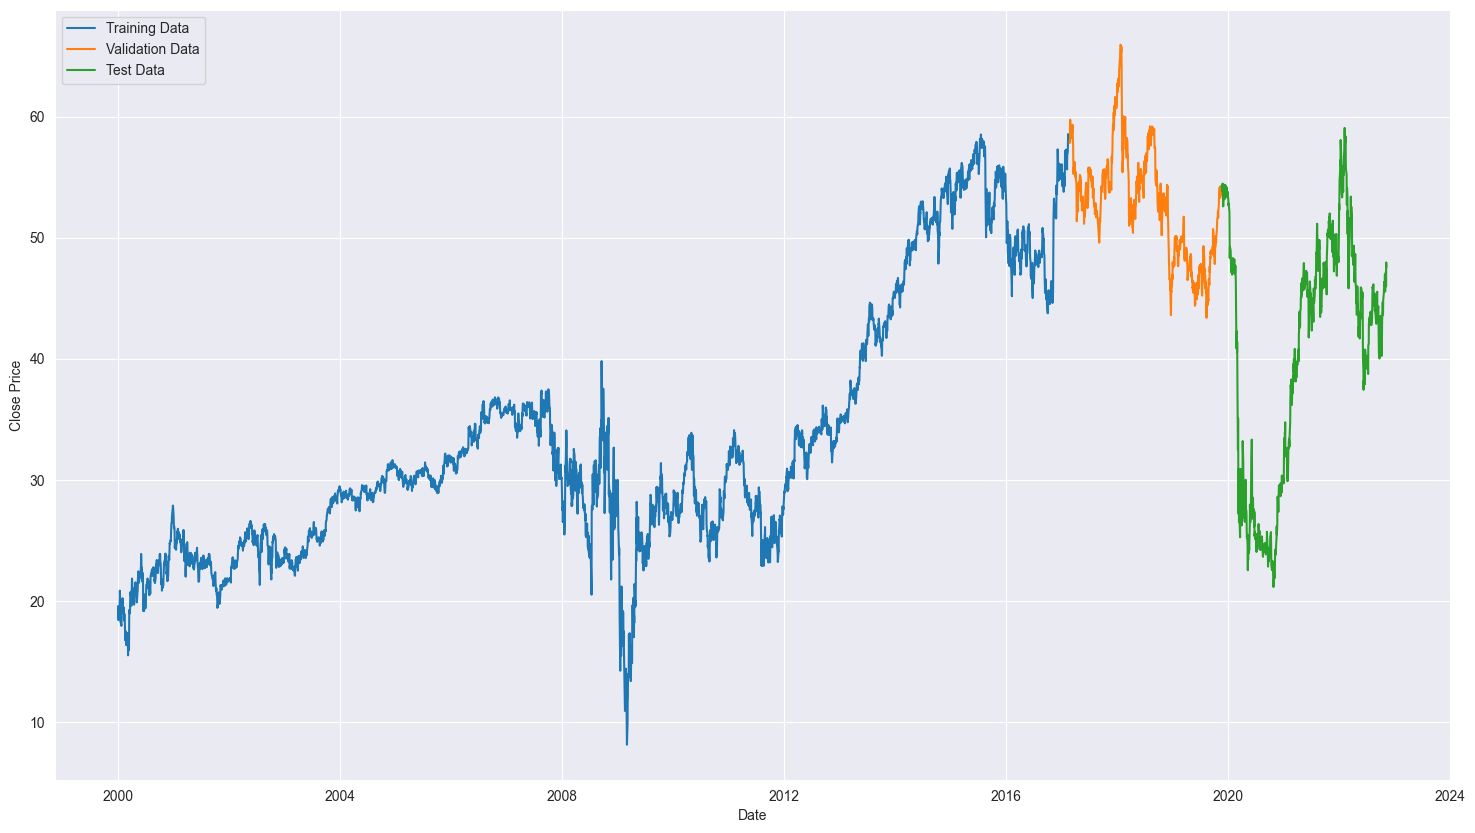

In [19]:
plt.figure(figsize=(18, 10))

plotSeries(train_df.Date, train_df.Close, "Training Data")
plotSeries(valid_df.Date, valid_df.Close, "Validation Data")
plotSeries(test_df.Date, test_df.Close, "Test Data")
plt.legend(loc='upper left')

# Feature Engineering

In [20]:
# How to add the Date columns after normalizing
# Maybe do TCS & infosys for better smoothing 

In [21]:
train_df.set_index(['Date'],inplace=True)
test_df.set_index(['Date'],inplace=True)
valid_df.set_index(['Date'],inplace=True)

In [22]:
trainNorm = train_df.Close.values.reshape(-1, 1)
testNorm = test_df.Close.values.reshape(-1, 1)
validNorm = valid_df.Close.values.reshape(-1, 1)

In [23]:
trainNorm.shape

(4313, 1)

## Windowed Dataset

In [24]:
mse_arr=[]
Z = []

window = 15

In [25]:
X_train= []
Y_train=[]
X_valid= []
Y_valid=[]
X_test= []
Y_test=[]

for i in range(len(trainNorm) - (window)):
    X_train.append(trainNorm[i:i+window])
    Y_train.append(trainNorm[i+window])
    
for i in range(len(validNorm) - (window)):
    X_valid.append(validNorm[i:i+window])
    Y_valid.append(validNorm[i+window])
    
for i in range(len(testNorm) - (window)):
    X_test.append(testNorm[i:i+window])
    Y_test.append(testNorm[i+window])
    

X_train=np.asanyarray(X_train)
Y_train=np.asanyarray(Y_train)
X_valid=np.asanyarray(X_valid)
Y_valid=np.asanyarray(Y_valid)
X_test=np.asanyarray(X_test)
Y_test=np.asanyarray(Y_test)

Xtrain = X_train[:,:,:]  
Ytrain = Y_train[:]  
Xvalid = X_valid[:,:,:]  
Yvalid= Y_valid[:]  
Xtest = X_test[:,:,:]  
Ytest= Y_test[:]  

# Model Building

In [26]:
tf.keras.backend.clear_session()
model = tf.keras.Sequential()

In [27]:
model.add(keras.layers.Conv1D(
    filters= 64,
    kernel_size=5, 
    strides= 1, 
    padding='same',
    activation='relu'
))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.Conv1D(
    filters= 128,
    kernel_size=5, 
    strides= 1, 
    padding='same',
    activation='relu'
))
model.add(keras.layers.MaxPooling1D(pool_size=2))
model.add(keras.layers.LSTM(128,return_sequences=True))
model.add(keras.layers.LSTM(64,return_sequences=False))
model.add(keras.layers.Dense(32, activation="relu"))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(16, activation="relu"))
model.add(keras.layers.Dropout(0.2))
model.add(keras.layers.Dense(1, activation="relu"))

## Find the Optimal Learning Rate

In [28]:
lrSchedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch:1e-8*10**(epoch/20))
earlyStop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=45, restore_best_weights=True)

In [29]:
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
             optimizer = optimizer,
             metrics = ["mae"])

In [30]:
history = model.fit(Xtrain,Ytrain, epochs=500, callbacks=[lrSchedule, earlyStop])

Epoch 1/500
135/135 [==============================] - 11s 12ms/step - loss: 32.3799 - mae: 32.8799 - lr: 1.0000e-08
Epoch 2/500
135/135 [==============================] - 1s 10ms/step - loss: 32.3772 - mae: 32.8772 - lr: 1.1220e-08
Epoch 3/500
135/135 [==============================] - 1s 10ms/step - loss: 32.3821 - mae: 32.8821 - lr: 1.2589e-08
Epoch 4/500
135/135 [==============================] - 1s 10ms/step - loss: 32.3821 - mae: 32.8821 - lr: 1.4125e-08
Epoch 5/500
135/135 [==============================] - 1s 11ms/step - loss: 32.3794 - mae: 32.8794 - lr: 1.5849e-08
Epoch 6/500
135/135 [==============================] - 2s 12ms/step - loss: 32.3802 - mae: 32.8802 - lr: 1.7783e-08
Epoch 7/500
135/135 [==============================] - 2s 14ms/step - loss: 32.3747 - mae: 32.8747 - lr: 1.9953e-08
Epoch 8/500
135/135 [==============================] - 2s 14ms/step - loss: 32.3774 - mae: 32.8774 - lr: 2.2387e-08
Epoch 9/500
135/135 [==============================] - 2s 14ms/step - l

135/135 [==============================] - 2s 13ms/step - loss: 10.1064 - mae: 10.5961 - lr: 3.1623e-05
Epoch 72/500
135/135 [==============================] - 2s 14ms/step - loss: 9.7745 - mae: 10.2626 - lr: 3.5481e-05
Epoch 73/500
135/135 [==============================] - 2s 14ms/step - loss: 9.1046 - mae: 9.5933 - lr: 3.9811e-05
Epoch 74/500
135/135 [==============================] - 2s 14ms/step - loss: 8.4969 - mae: 8.9843 - lr: 4.4668e-05
Epoch 75/500
135/135 [==============================] - 2s 14ms/step - loss: 8.0619 - mae: 8.5486 - lr: 5.0119e-05
Epoch 76/500
135/135 [==============================] - 2s 14ms/step - loss: 7.8565 - mae: 8.3432 - lr: 5.6234e-05
Epoch 77/500
135/135 [==============================] - 2s 15ms/step - loss: 7.5142 - mae: 8.0000 - lr: 6.3096e-05
Epoch 78/500
135/135 [==============================] - 2s 14ms/step - loss: 7.6101 - mae: 8.0962 - lr: 7.0795e-05
Epoch 79/500
135/135 [==============================] - 2s 15ms/step - loss: 7.2063 - mae:

135/135 [==============================] - 2s 14ms/step - loss: 7.2343 - mae: 7.7143 - lr: 0.1259
Epoch 144/500
135/135 [==============================] - 2s 14ms/step - loss: 7.2383 - mae: 7.7184 - lr: 0.1413
Epoch 145/500
135/135 [==============================] - 2s 15ms/step - loss: 7.2365 - mae: 7.7155 - lr: 0.1585
Epoch 146/500
135/135 [==============================] - 2s 13ms/step - loss: 7.2430 - mae: 7.7226 - lr: 0.1778
Epoch 147/500
135/135 [==============================] - 2s 14ms/step - loss: 7.2362 - mae: 7.7147 - lr: 0.1995
Epoch 148/500
135/135 [==============================] - 2s 14ms/step - loss: 7.2445 - mae: 7.7263 - lr: 0.2239
Epoch 149/500
135/135 [==============================] - 2s 14ms/step - loss: 7.2470 - mae: 7.7257 - lr: 0.2512
Epoch 150/500
135/135 [==============================] - 2s 14ms/step - loss: 7.2356 - mae: 7.7165 - lr: 0.2818
Epoch 151/500
135/135 [==============================] - 2s 14ms/step - loss: 7.2511 - mae: 7.7318 - lr: 0.3162
Epoch 

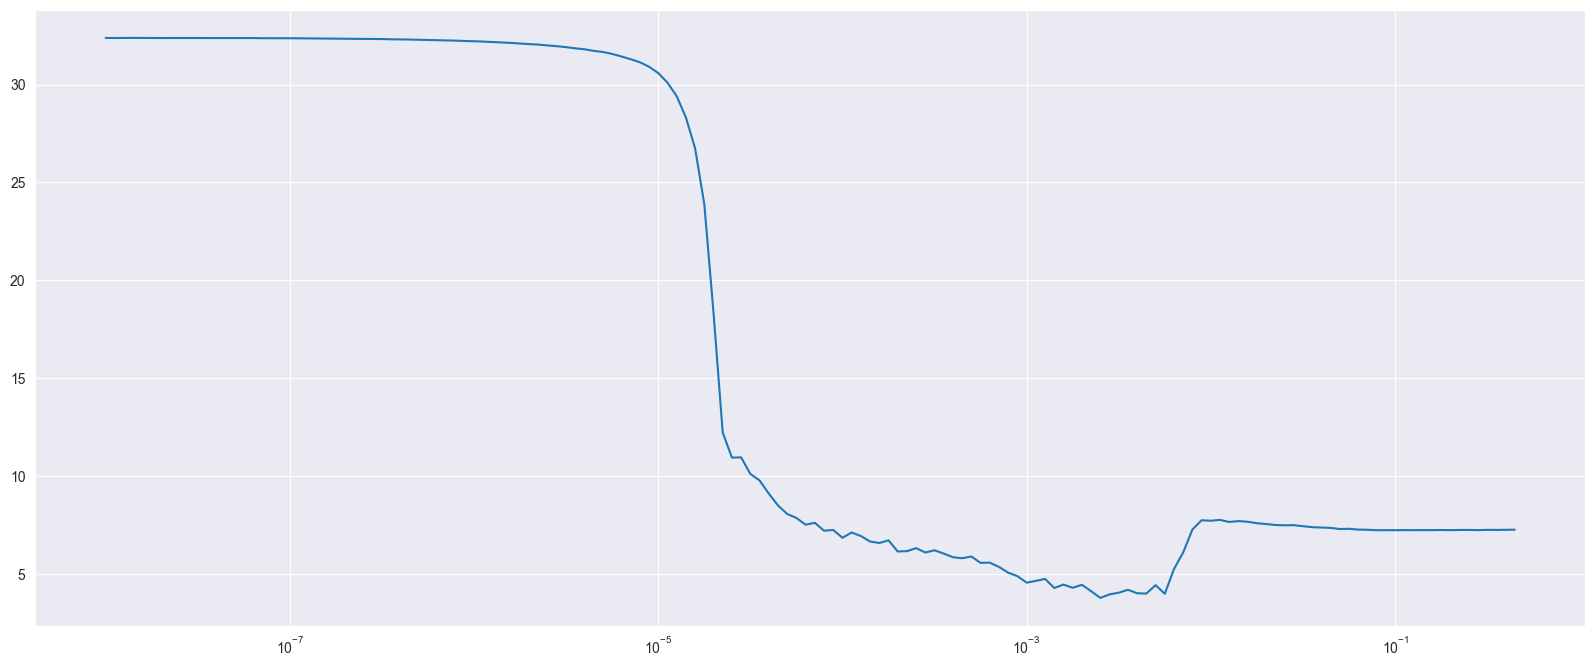

In [31]:
plt.figure(figsize=(20,8))
plt.semilogx(history.history["lr"], history.history["loss"])
#plt.axis([1e-8, 1e-4, 0, 30])

(0.0001, 0.01, 0.0, 10.0)

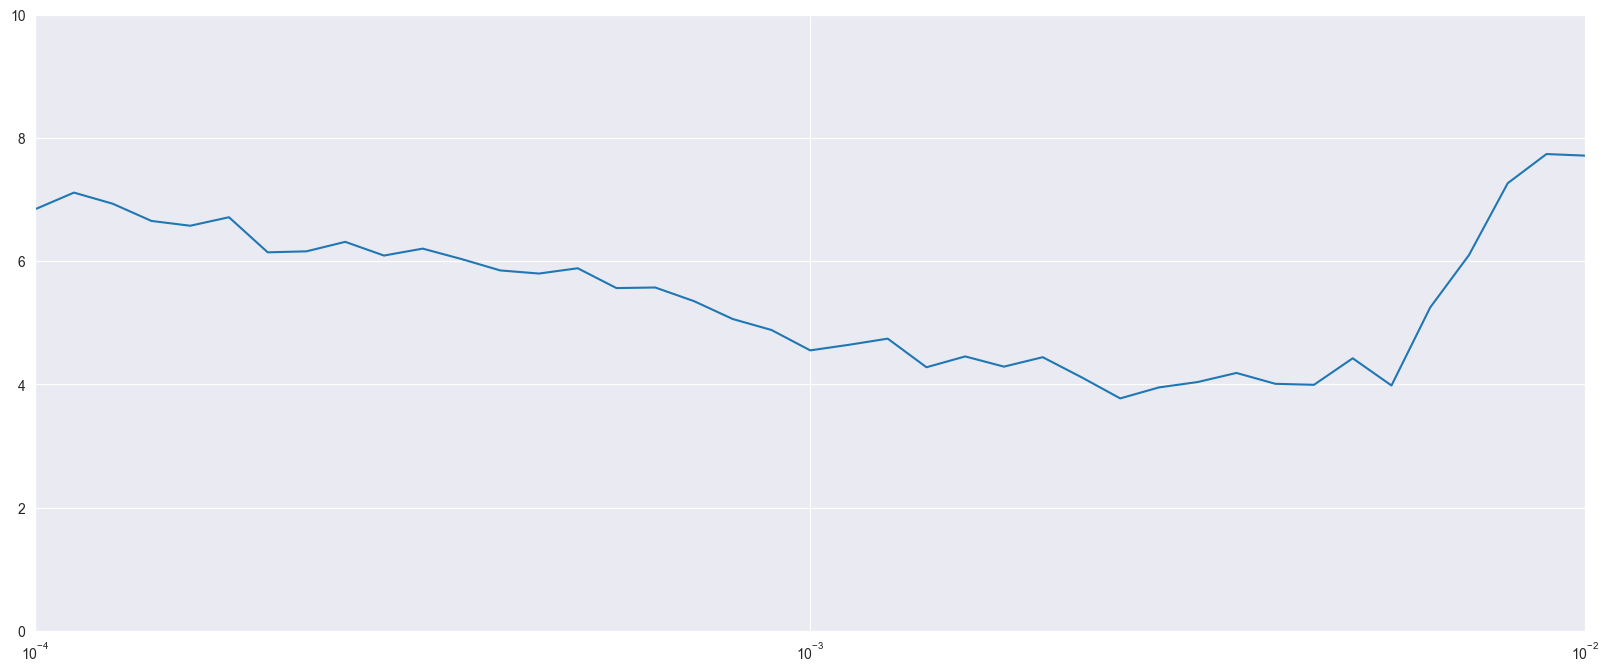

In [32]:
plt.figure(figsize=(20,8))
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-4, 1e-2, 0, 10])

# Final Model Build

In [33]:
#### Clear Session part & random.seeds()
tf.keras.backend.clear_session()
tf.random.set_seed(99)

In [34]:
model.compile(loss=tf.keras.losses.MeanAbsoluteError(), #Huber/Psedu-Huber
              optimizer=Adam(8e-2),
              metrics=['mae'])

In [35]:
log_dir = "logs\\" + datetime.datetime.now().strftime("%d-%m-%Y_%H%M%S")

tensorboard_callback = [
#                         tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
#                         ModelCheckpoint(model_path, verbose=1, save_best_only=True),
#                         ReduceLROnPlateau(monitor= "val_mae", factor=0.1, patience=5, min_lr=1e-7, verbose=1),
                        ReduceLROnPlateau(monitor='val_mae', factor=0.2,patience=5, min_lr=1e-6, verbose=1),
#                         CSVLogger(csv_path),
                        TensorBoard(),
                        EarlyStopping(monitor= "val_mae", patience=10, restore_best_weights=True)
                       ]

In [36]:
# model.fit(
#     train_dataset,
#     epochs=num_epochs,
#     validation_data=valid_dataset,
#     steps_per_epoch=train_steps,
#     validation_steps=valid_steps,
#     callbacks=callbacks
# )

In [37]:
history = model.fit(Xtrain, Ytrain,batch_size=128, epochs=100, verbose=1,validation_data=(Xvalid, Yvalid), callbacks=tensorboard_callback)

Epoch 1/100
34/34 [==============================] - 7s 59ms/step - loss: 11.8547 - mae: 11.8547 - val_loss: 27.3797 - val_mae: 27.3797 - lr: 0.0800
Epoch 2/100
34/34 [==============================] - 0s 14ms/step - loss: 9.1976 - mae: 9.1976 - val_loss: 24.2144 - val_mae: 24.2144 - lr: 0.0800
Epoch 3/100
34/34 [==============================] - 0s 14ms/step - loss: 9.1299 - mae: 9.1299 - val_loss: 26.1963 - val_mae: 26.1963 - lr: 0.0800
Epoch 4/100
34/34 [==============================] - 0s 12ms/step - loss: 9.0132 - mae: 9.0132 - val_loss: 27.3940 - val_mae: 27.3940 - lr: 0.0800
Epoch 5/100
34/34 [==============================] - 0s 13ms/step - loss: 8.8218 - mae: 8.8218 - val_loss: 24.0081 - val_mae: 24.0081 - lr: 0.0800
Epoch 6/100
34/34 [==============================] - 0s 13ms/step - loss: 8.7883 - mae: 8.7883 - val_loss: 23.3379 - val_mae: 23.3379 - lr: 0.0800
Epoch 7/100
34/34 [==============================] - 0s 12ms/step - loss: 8.5987 - mae: 8.5987 - val_loss: 25.7960 -

In [38]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 15, 64)            384       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 7, 64)            0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 128)            41088     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 128)           0         
 1D)                                                             
                                                                 
 lstm (LSTM)                 (None, 3, 128)            131584    
                                                                 
 lstm_1 (LSTM)               (None, 64)                4

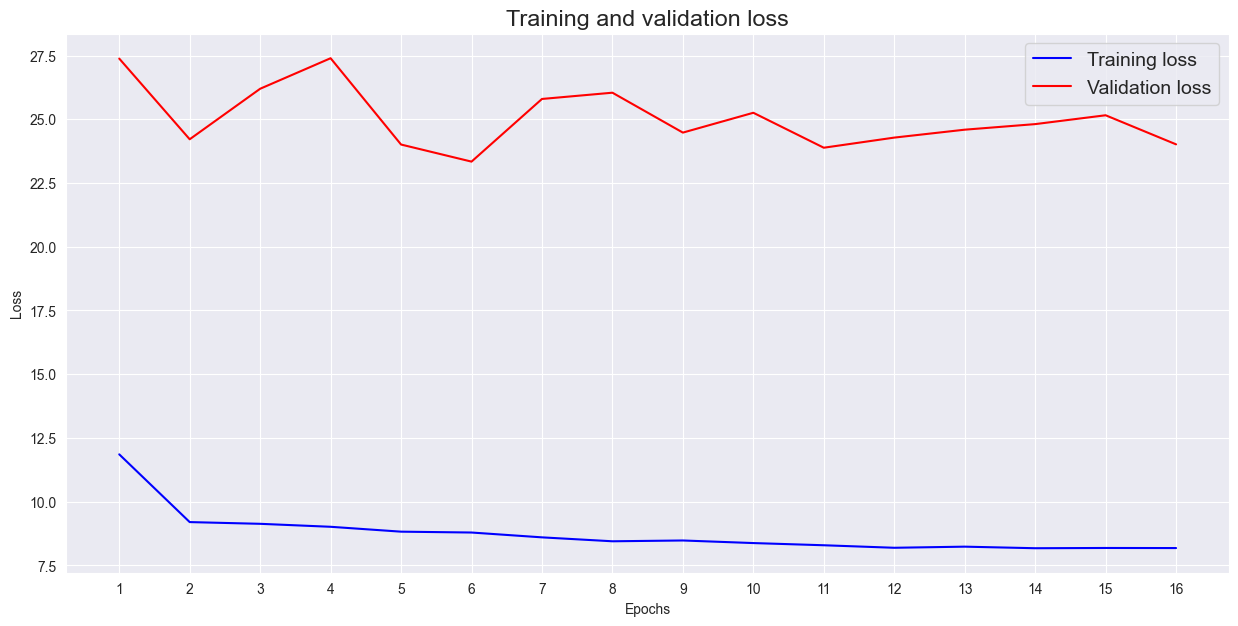

In [39]:
#Showing training and validation loss
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
loss_values50 = loss_values[0:150]
val_loss_values50 = val_loss_values[0:150]
epochs = range(1, len(loss_values50) + 1)
plt.plot(epochs, loss_values50, 'b',color = 'blue', label='Training loss')
plt.plot(epochs, val_loss_values50, 'b',color='red', label='Validation loss')
plt.rc('font', size = 14)
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(15,7)
#fig.savefig('test&validationlosscnn.png', dpi=300)
plt.show()

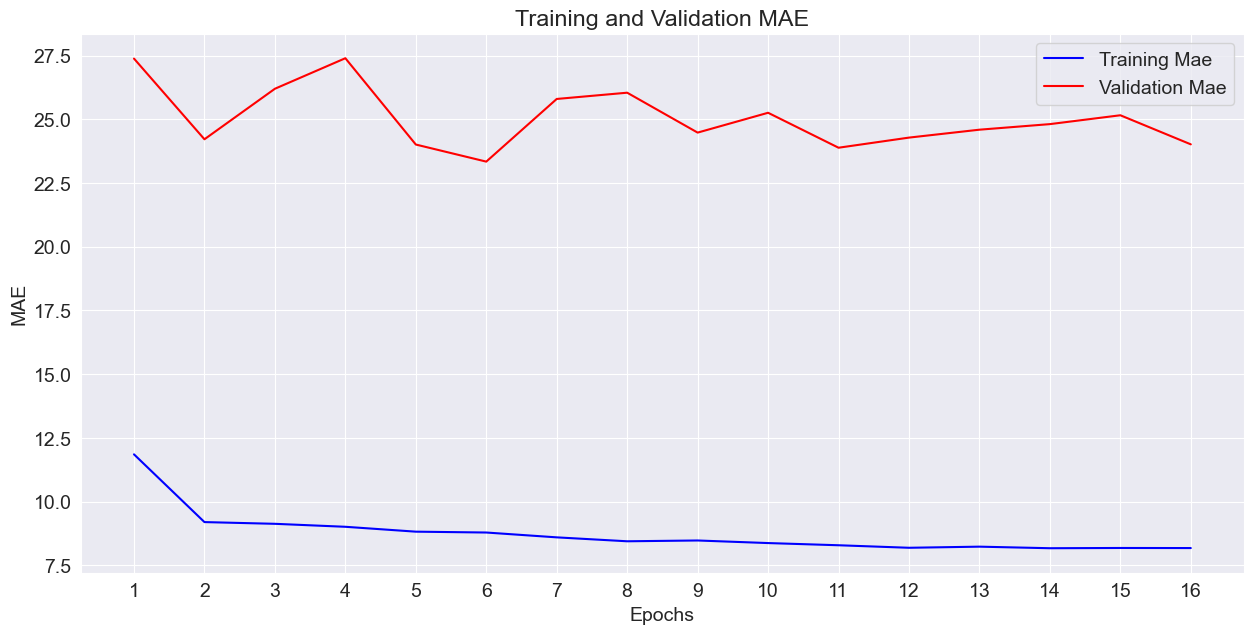

In [40]:
loss_values = history_dict['mae']
val_loss_values = history_dict['val_mae']
loss_values50 = loss_values[0:150]
val_loss_values50 = val_loss_values[0:150]
epochs = range(1, len(loss_values50) + 1)
plt.plot(epochs, loss_values50, 'b',color = 'blue', label='Training Mae')
plt.plot(epochs, val_loss_values50, 'b',color='red', label='Validation Mae')
plt.rc('font', size = 14)
plt.title('Training and Validation MAE')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.xticks(epochs)
fig = plt.gcf()
fig.set_size_inches(15,7)
#fig.savefig('test&validationlosscnn.png', dpi=300)
plt.show()

In [41]:
#Evaluating model
trainScore = model.evaluate(Xtrain, Ytrain, verbose=1)
testScore = model.evaluate(Xtest, Ytest, verbose=1)

23/23 [==============================] - 0s 8ms/step - loss: 12.5600 - mae: 12.5600


In [42]:
testScore

[12.559976577758789, 12.559976577758789]

In [43]:
preds = model.predict(Xtest)

23/23 [==============================] - 1s 5ms/step


In [44]:
Xtest.shape

(734, 15, 1)

In [45]:
Ytest

array([[54.220001],
       [54.34    ],
       [53.669998],
       [53.630001],
       [53.330002],
       [53.810001],
       [53.82    ],
       [54.150002],
       [53.919998],
       [53.599998],
       [53.799999],
       [53.75    ],
       [53.419998],
       [53.099998],
       [52.66    ],
       [52.82    ],
       [52.73    ],
       [52.5     ],
       [52.110001],
       [49.299999],
       [48.32    ],
       [49.25    ],
       [49.18    ],
       [48.939999],
       [48.560001],
       [48.220001],
       [47.57    ],
       [47.099998],
       [47.369999],
       [47.27    ],
       [47.91    ],
       [46.939999],
       [47.119999],
       [47.259998],
       [48.310001],
       [47.98    ],
       [47.84    ],
       [47.77    ],
       [47.990002],
       [47.790001],
       [48.119999],
       [48.220001],
       [46.990002],
       [47.09    ],
       [47.34    ],
       [47.700001],
       [46.389999],
       [45.119999],
       [44.139999],
       [42.470001],


###### 

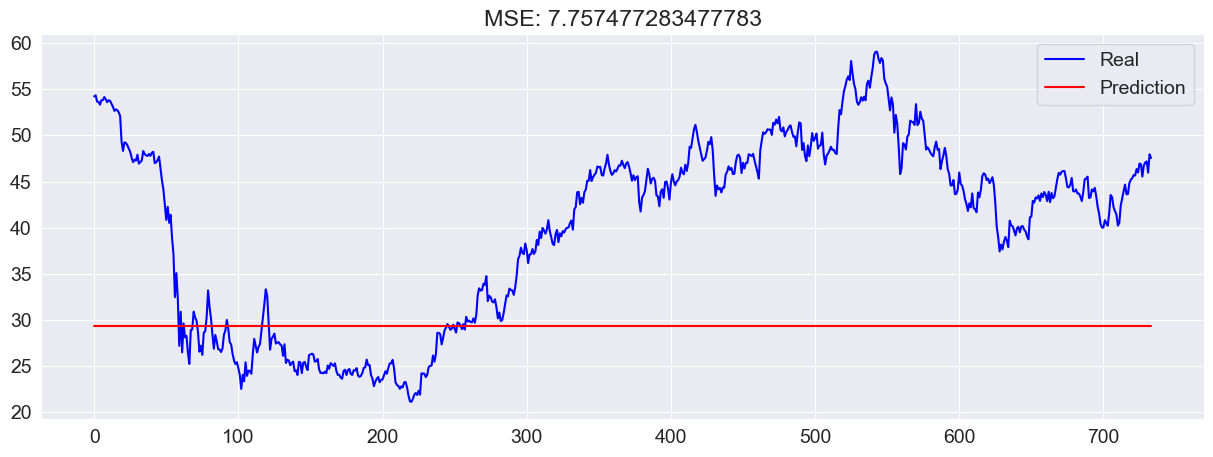

In [46]:

plt.figure(figsize=(15,5))
plt.title('MSE: {}'.format(trainScore[0]))
plt.plot(Ytest, 'b', label='Real')
plt.plot(preds, 'r', label='Prediction')

plt.legend(loc="best")

#for saving figures
# plt.savefig('CPALL_graph.png')
plt.show()

In [47]:
#denormalizing datasets
# preds = scaler.inverse_transform(preds)
# Ytest = scaler.inverse_transform(Ytest)

In [48]:
#Show Train and Test Scores
print('Train MSE \t Train RMSE \t Train MAE \t Testscore RMSE \tTest MSE \tTest MAE')
print('%.9f \t %.9f \t %.9f \t %.9f \t \t %.9f \t %.9f' % (trainScore[0], math.sqrt(trainScore[0]),trainScore[1],math.sqrt(testScore[0]),testScore[0],testScore[1]))

Train MSE 	 Train RMSE 	 Train MAE 	 Testscore RMSE 	Test MSE 	Test MAE
7.757477283 	 2.785224817 	 7.757477283 	 3.544005725 	 	 12.559976578 	 12.559976578


In [49]:
print('MAE \t\t MAPE')
print('%.4f \t\t %.4f' % (mean_absolute_error(Ytest,preds),(np.mean(np.abs((Ytest - preds) / Ytest)) * 100)))

MAE 		 MAPE
12.5600 		 28.6754
